In [26]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import os
import requests
from scipy import stats
import ast
import seaborn as sns
from scipy.stats import kruskal

In [2]:
metrics = [
    "Function Words (%)",
    "# sentences",
    "Avg. Sentence Length",
    "Pronouns (%)",
    "# Words",
    "Avg. Word Length",
]

DATASET_TO_NAME = {
    "essays": "Personality",
    "wassa": "Empathy",
    "facebook": "Morality",
    "political": "Senate",
    "reddit": "Reddit",
    "news": "Patch news",
    "papers": "ArXiv",
}

DATASET_TO_DATASET_NAME = {
    "essays": "Essays",
    "wassa": "Empathetic C.",
    "facebook": "YourMorals",
    "political": "Congress",
    "reddit": "Reddit",
    "news": "Patch news",
    "papers": "ArXiv",
}

BASELINES = {
    "CON": 0.5110732538330494,
    "EXT": 0.5157580919931857,
    "AGR": 0.530664395229983,
    "NEU": 0.5008517887563884,
    "OPN": 0.5161839863713799,
    ".care": 0.5070035704476792,
    ".purity": 0.5358418017028289,
    ".fairness": 0.5281516067014557,
    ".loyalty": 0.5034331227684702,
    ".authority": 0.5339192529524857,
    ".iri.concern": 0.5724331926863573,
    ".iri.distress": 0.5175808720112518,
    ".iri.fantasy": 0.5471167369901547,
    ".iri.perspective": 0.5274261603375527,
}

REWRITTEN_TYPE_TO_SHORT = {
    "syntax_grammar": "SG",
    "rephrase": "R",
}

LLM_TO_NAME = {
    "original": "Original",
    "gpt": "GPT3.5",
    "llama": "Llama 3",
    "gemini": "Gemini",
}

LABELS_TO_NAME = {
    ".iri.concern": "Concern",
    ".iri.distress": "Distress",
    ".iri.perspective": "Perspective",
    ".iri.fantasy": "Fantasy",
    ".authority": "Authority",
    ".care": "Care",
    ".fairness": "Fairness",
    ".loyalty": "Loyalty",
    ".purity": "Purity",
    "CON": "CON",
    "NEU": "NEU",
    "EXT": "EXT",
    "AGR": "AGR",
    "OPN": "OPN",
}

In [3]:
def get_embeddings(list_of_ids, list_of_texts, results_embeddings={}):
    for _id, essay in tqdm(zip(list_of_ids, list_of_texts), total=len(list_of_ids)):
        if str(_id) in results_embeddings.keys():
            continue
        api_key = os.environ.get("OPENAI_API_KEY")
        url = "https://api.openai.com/v1/embeddings"
        headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        }
        data = {
            "input": essay,
            "model": "text-embedding-ada-002",
            "encoding_format": "float",
        }

        # Send the POST request
        response = requests.post(url, headers=headers, json=data)

        # Check the response status and content
        if response.status_code == 200:
            # Successful request, you can access the response data using response.json()
            response_data = response.json()
            results_embeddings[str(_id)] = response_data
        else:
            # Request failed, print the error message
            print(
                f"Request failed with status code {response.status_code}: {response.text}"
            )
            continue
    return results_embeddings

In [4]:
from lang_dicts import function_words, pronouns

In [5]:
def get_percentage_function_words(essay):
    words = essay.split()
    words = [word.lower() for word in words]
    function_words_lower = [word.lower() for word in function_words]
    count = 0
    for function_word in function_words_lower:
        count += words.count(function_word)
    num_words = len(words)
    return count / num_words


def get_percentage_pronouns(essay):
    words = essay.split()
    words = [word.lower() for word in words]
    pronouns_lower = [word.lower() for word in pronouns]
    count = 0
    for pronoun in pronouns_lower:
        count += words.count(pronoun)
    num_words = len(words)
    return count / num_words


def get_num_sentences(essay):
    return len(essay.split("."))


def get_avg_lengths_of_sentences(essay):
    sentences = essay.split(".")
    sentences = [sentence for sentence in sentences if len(sentence.split()) > 0]
    lengths = [len(sentence.split()) for sentence in sentences]
    return np.mean(lengths)


def get_num_words(essay):
    return len(essay.split())


def mean_length_of_words_used(essay):
    words = essay.split()
    words = [word.lower() for word in words]
    lengths = [len(word) for word in words]
    return np.mean(lengths)


def apply_funcs_to_essays(ids_to_texts):
    results = {}
    for func, name in zip(
        [
            get_percentage_function_words,
            get_percentage_pronouns,
            get_num_sentences,
            get_avg_lengths_of_sentences,
            get_num_words,
            mean_length_of_words_used,
        ],
        [
            "get_percentage_function_words",
            "get_percentage_pronouns",
            "get_num_sentences",
            "get_avg_lengths_of_sentences",
            "get_num_words",
            "mean_length_of_words_used",
        ],
    ):
        results[name] = dict(
            zip(ids_to_texts.keys(), [func(text) for text in ids_to_texts.values()])
        )
    return results

In [6]:
def get_stats():
    if os.path.exists("stats.csv"):
        df = pd.read_csv("stats.csv")
        for metric in metrics:
            df[metric] = df[metric].apply(lambda x: ast.literal_eval(x))
        return df
    dataset_category_to_original_file = {
        "facebook": "full_dataset_clean.csv",
        "wassa": "clean_wassa.csv",
        "essays": "essays_anon_full.csv",
        "political": "clean_data_agg.csv",
    }

    dataset_category_to_id_column = {
        "facebook": "subject_id",
        "wassa": "id",
        "essays": "#AUTHID",
        "political": "speakerid",
    }

    rewritten_file = "{}_rewritten_{}_{}_cleaned.csv"

    results_llm_model = []
    results_dataset = []
    results_rewritten_type = []

    results_percentage_function_words = []
    results_percentage_pronouns = []
    results_num_sentences = []
    results_avg_lengths_of_sentences = []
    results_num_words = []
    results_mean_length_of_words_used = []

    for dataset in tqdm(dataset_category_to_original_file.keys(), leave=False):
        for llm_model in tqdm(["gpt", "llama", "gemini"], leave=False):
            for rewritten_type in tqdm(
                ["original", "syntax_grammar", "rephrase"], leave=False
            ):
                if rewritten_type == "original":
                    file_name = os.path.join(
                        dataset, dataset_category_to_original_file[dataset]
                    )
                else:
                    file_name = os.path.join(
                        dataset,
                        rewritten_file.format(dataset, rewritten_type, llm_model),
                    )
                df = pd.read_csv(file_name)
                df[dataset_category_to_id_column[dataset]] = df[
                    dataset_category_to_id_column[dataset]
                ].astype(str)

                df = df.dropna(subset=["text"])
                df["text"] = df["text"].astype(str)

                ids_to_texts = dict(
                    zip(
                        df[dataset_category_to_id_column[dataset]].tolist(),
                        df["text"].tolist(),
                    )
                )

                ids_to_texts = {
                    id_: text
                    for id_, text in ids_to_texts.items()
                    if len(text.split()) > 0
                }

                results_llm_model.append(llm_model)
                results_dataset.append(dataset)
                results_rewritten_type.append(rewritten_type)

                results_dicts = apply_funcs_to_essays(ids_to_texts)

                results_percentage_function_words.append(
                    results_dicts["get_percentage_function_words"]
                )
                results_percentage_pronouns.append(
                    results_dicts["get_percentage_pronouns"]
                )
                results_num_sentences.append(results_dicts["get_num_sentences"])
                results_avg_lengths_of_sentences.append(
                    results_dicts["get_avg_lengths_of_sentences"]
                )
                results_num_words.append(results_dicts["get_num_words"])
                results_mean_length_of_words_used.append(
                    results_dicts["mean_length_of_words_used"]
                )

    stats_df = pd.DataFrame(
        {
            "dataset": results_dataset,
            "rewritten_type": results_rewritten_type,
            "llm_model": results_llm_model,
            "Function Words (%)": results_percentage_function_words,
            "Pronouns (%)": results_percentage_pronouns,
            "# sentences": results_num_sentences,
            "Avg. Sentence Length": results_avg_lengths_of_sentences,
            "# Words": results_num_words,
            "Avg. Word Length": results_mean_length_of_words_used,
        }
    )

    stats_df.to_csv("stats.csv", index=False)

    return stats_df

In [7]:
def compute_metric_diffs(stats_df):

    all_datasets = []
    all_llm_models = []
    all_rewritten_types = []
    all_metrics = []
    all_original_values = []
    all_rewritten_values = []
    all_p_values = []

    for dataset in stats_df["dataset"].unique():
        for llm_model in stats_df["llm_model"].unique():

            for rewritten_type in ["syntax_grammar", "rephrase"]:

                dataset_df = stats_df[
                    (stats_df["dataset"] == dataset)
                    & (stats_df["llm_model"] == llm_model)
                ].copy()

                for metric in metrics:
                    original_ids_values = dataset_df[
                        (dataset_df["rewritten_type"] == "original")
                    ][metric].values[0]
                    rewritten_ids_values = dataset_df[
                        (dataset_df["rewritten_type"] == rewritten_type)
                    ][metric].values[0]

                    original_ids = original_ids_values.keys()
                    rewritten_ids = rewritten_ids_values.keys()
                    ids_in_both = set(original_ids).intersection(set(rewritten_ids))

                    original_values = [original_ids_values[key] for key in ids_in_both]
                    rewritten_values = [
                        rewritten_ids_values[key] for key in ids_in_both
                    ]

                    _, p_value = stats.ttest_ind(original_values, rewritten_values)

                    all_datasets.append(dataset)
                    all_llm_models.append(llm_model)
                    all_rewritten_types.append(rewritten_type)
                    all_p_values.append(p_value)
                    all_original_values.append(np.mean(original_values))
                    all_rewritten_values.append(np.mean(rewritten_values))
                    all_metrics.append(metric)

    return pd.DataFrame(
        {
            "dataset": all_datasets,
            "llm_model": all_llm_models,
            "rewritten_type": all_rewritten_types,
            "metric": all_metrics,
            "original_value": all_original_values,
            "rewritten_value": all_rewritten_values,
            "p_value": all_p_values,
        }
    )

In [8]:
stats_df = get_stats()
stats_metric_diffs = compute_metric_diffs(stats_df)
# stats_metric_diffs = stats_metric_diffs[
# stats_metric_diffs["p_value"] < 0.05
# ]  # so it's good not to consider # sentences since it's not significant
stats_metric_diffs.drop(["p_value"], axis=1, inplace=True)
stats_metric_diffs["rewritten_higher"] = stats_metric_diffs.apply(
    lambda x: x["rewritten_value"] > x["original_value"], axis=1
)

In [9]:
stats_df.head(3)

,dataset,rewritten_type,llm_model,Function Words (%),Pronouns (%),# sentences,Avg. Sentence Length,# Words,Avg. Word Length
0,facebook,original,gpt,"{'66149': 0.510178117048346, '98095': 0.597345...","{'66149': 0.09796437659033079, '98095': 0.1150...","{'66149': 34, '98095': 10, '186986': 20, '1916...","{'66149': 25.0, '98095': 28.625, '186986': 15....","{'66149': 786, '98095': 226, '186986': 307, '1...","{'66149': 4.56234096692112, '98095': 4.8008849..."
1,facebook,syntax_grammar,gpt,"{'66149': 0.522075055187638, '98095': 0.588744...","{'66149': 0.12693156732891833, '98095': 0.0995...","{'66149': 58, '98095': 15, '186986': 28, '1916...","{'66149': 16.29824561403509, '98095': 15.86666...","{'66149': 906, '98095': 231, '186986': 375, '1...","{'66149': 4.939293598233996, '98095': 5.108225..."
2,facebook,rephrase,gpt,"{'66149': 0.523704520396913, '98095': 0.555555...","{'66149': 0.12238147739801543, '98095': 0.1239...","{'66149': 56, '98095': 15, '186986': 27, '1916...","{'66149': 17.528301886792452, '98095': 15.9333...","{'66149': 907, '98095': 234, '186986': 360, '1...","{'66149': 4.990077177508269, '98095': 4.923076..."


In [10]:
all_datasets = []
all_llm_models = []
all_metrics = []
all_original_values = []
all_ids = []
for _, row in stats_df[stats_df["rewritten_type"] == "original"].iterrows():
    for metric in metrics:
        for id_ in row[metric].keys():
            all_datasets.append(row["dataset"])
            all_llm_models.append(row["llm_model"])
            all_metrics.append(metric)
            all_original_values.append(row[metric][id_])
            all_ids.append(id_)

all_original_values_df = pd.DataFrame(
    {
        "dataset": all_datasets,
        "llm_model": all_llm_models,
        "metric": all_metrics,
        "original_value": all_original_values,
        "id": all_ids,
    }
)

all_datasets = []
all_llm_models = []
all_metrics = []
all_rewritten_values = []
all_ids = []
all_prompts = []
for prompt in ["syntax_grammar", "rephrase"]:
    for _, row in stats_df[stats_df["rewritten_type"] == prompt].iterrows():
        for metric in metrics:
            for id_ in row[metric].keys():
                all_datasets.append(row["dataset"])
                all_llm_models.append(row["llm_model"])
                all_metrics.append(metric)
                all_rewritten_values.append(row[metric][id_])
                all_ids.append(id_)
                all_prompts.append(prompt)

all_rewritten_values_df = pd.DataFrame(
    {
        "dataset": all_datasets,
        "llm_model": all_llm_models,
        "metric": all_metrics,
        "rewritten_value": all_rewritten_values,
        "id": all_ids,
        "prompt": all_prompts,
    }
)

In [11]:
merged_df = pd.merge(
    all_original_values_df,
    all_rewritten_values_df,
    on=["dataset", "llm_model", "metric", "id"],
    how="inner",
)

In [12]:
merged_df.to_csv("all_lexical_stats.csv", index=False)

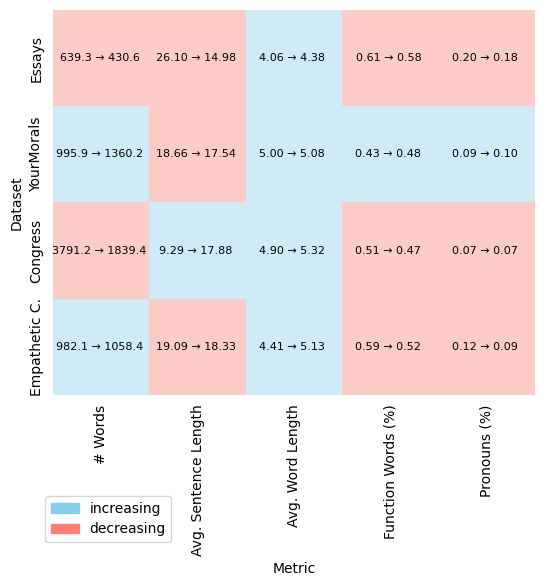

In [13]:
df_to_visualize = (
    stats_metric_diffs[stats_metric_diffs["metric"] != "# sentences"]
    .groupby(["dataset", "metric"])["rewritten_higher"]
    .mean()
    > 0.5
).unstack()
original_values = (
    stats_metric_diffs[stats_metric_diffs["metric"] != "# sentences"]
    .groupby(["dataset", "metric"])["original_value"]
    .mean()
    .unstack()
    .values
)
rewritten_values = (
    stats_metric_diffs[stats_metric_diffs["metric"] != "# sentences"]
    .groupby(["dataset", "metric"])["rewritten_value"]
    .mean()
    .unstack()
    .values
)
indices = df_to_visualize.index
columns = (
    stats_metric_diffs[stats_metric_diffs["metric"] != "# sentences"]
    .groupby(["dataset", "metric"])["original_value"]
    .mean()
    .unstack()
    .columns.tolist()
)
values = df_to_visualize.values

fig, ax = plt.subplots(figsize=(10, 5))
# make a heatmap based on colors and the inside of the cells the values
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("my_cmap", ["salmon", "skyblue"], 2)
plt.imshow(values, cmap=cmap, alpha=0.4)
for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        plt.text(
            j,
            i,
            (
                f"{original_values[i, j]:.2f} \u2192 {rewritten_values[i, j]:.2f} "
                if original_values[i, j] < 100
                else f"{original_values[i, j]:.1f} \u2192 {rewritten_values[i, j]:.1f} "
            ),
            ha="center",
            va="center",
            color="black",
            fontsize=8,
        )

plt.xticks(
    [x + 0.0 for x in range(len(columns))],
    columns,
    rotation=90,
    ha="center",
    # va="center",
    # x=1.5,
)
plt.yticks(
    range(len(indices)),
    [DATASET_TO_DATASET_NAME[index] for index in indices],
    rotation=90,
    va="center",
)
plt.xlabel("Metric")
plt.ylabel("Dataset")

# draw the gradient bar without frame
# cbar = plt.colorbar()
# cbar.outline.set_visible(False)

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color="skyblue", label="increasing")
blue_patch = mpatches.Patch(color="salmon", label="decreasing")

plt.legend(
    handles=[red_patch, blue_patch],
    loc="lower right",
    bbox_to_anchor=(0.26, -0.40),
    ncol=1,
)

# remove the ticks
plt.tick_params(axis="both", which="both", bottom=False, top=False, left=False)
# remove the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)


plt.savefig("figures/metrics_diffs.png", bbox_inches="tight", dpi=300)
plt.show()

## Check the semantic similarity of the original essays and the rewritten essays

In [ ]:
from collections import defaultdict

similarities_dict_llms = defaultdict(dict)
for model_in_use in ["gpt", "llama", "gemini"]:
    similarities_dict_llms[model_in_use] = {}

    for dataset_category in [
        "essays",
        "facebook",
        "wassa",
        "political",
    ]:  # add facebook when it's ready later
        dataset_category_to_id_column = {
            "facebook": "subject_id",
            "wassa": "id",
            "essays": "#AUTHID",
            "political": "speakerid",
        }
        dataset_category_to_original_file_name = {
            "facebook": "full_dataset_clean",
            "wassa": "clean_wassa",
            "essays": "essays_anon_full",
            "political": "clean_data_agg",
        }
        id_column = dataset_category_to_id_column[dataset_category]
        orig_file_name = dataset_category_to_original_file_name[dataset_category]

        prompts = ["syntax_grammar", "rephrase"]

        for prompt in prompts:
            original_embeddings_path = (
                f"{dataset_category}/{orig_file_name}_embeddings.json"
            )

            rewritten_embeddings_path = f"{dataset_category}/{dataset_category}_rewritten_{prompt}_{model_in_use}_cleaned_embeddings.json"

            original_essays_df = pd.read_csv(f"{dataset_category}/{orig_file_name}.csv")
            original_essays_df[id_column] = original_essays_df[id_column].astype(str)
            rewritten_essays_df = pd.read_csv(
                f"{dataset_category}/{dataset_category}_rewritten_{prompt}_{model_in_use}_cleaned.csv"
            )
            rewritten_essays_df[id_column] = rewritten_essays_df[id_column].astype(str)

            original_id_to_text = dict(
                zip(original_essays_df[id_column], original_essays_df["text"])
            )
            rewrittens_id_to_text = dict(
                zip(rewritten_essays_df[id_column], rewritten_essays_df["text"])
            )

            with open(original_embeddings_path, "r") as f:
                original_embeddings = json.load(f)
            with open(rewritten_embeddings_path, "r") as f:
                rewritten_embeddings = json.load(f)
            keys = list(
                set.intersection(
                    set(original_embeddings.keys()), set(rewritten_embeddings.keys())
                )
            )
            print(
                "number of the keys intersecting between the original essays and the rewritten essays: ",
                len(keys),
            )

            original_embeddings = {
                key: data["data"][0]["embedding"]
                for key, data in original_embeddings.items()
            }
            rewritten_embeddings = {
                key: data["data"][0]["embedding"]
                for key, data in rewritten_embeddings.items()
            }

            similarities = dict()
            for key in tqdm(keys):
                original_embedding = original_embeddings[key]
                rewritten_embedding = rewritten_embeddings[key]
                similarity = cosine_similarity(
                    [original_embedding], [rewritten_embedding]
                )[0][0]
                similarities[key] = similarity

            # for key, similarity in zip(keys, similarities):
            #     if similarity < 0.5:
            #         print(key, similarity)
            #         print(original_id_to_text[key])
            #         print("-------------------")
            #         print(rewrittens_id_to_text[key])
            #         ids = [key, key + "rewritten"]
            #         texts = [original_id_to_text[key], rewrittens_id_to_text[key]]
            #         new_embeddings = get_embeddings(ids, texts)
            #         new_embeddings = {
            #             key: data["data"][0]["embedding"]
            #             for key, data in new_embeddings.items()
            #         }
            #         new_similarity = cosine_similarity(
            #             [new_embeddings[key]], [new_embeddings[key + "rewritten"]]
            #         )[0][0]
            #         print(new_similarity)
            similarities_dict_llms[model_in_use][
                (
                    dataset_category,
                    f"{REWRITTEN_TYPE_TO_SHORT[prompt]}",
                )
            ] = similarities

In [15]:
import pickle

with open("similarities_dict_with_keys.pkl", "wb") as f:
    pickle.dump(similarities_dict_llms, f)

In [16]:
used_llms = []
used_ids = []
used_prompts = []
used_dataset = []
computed_similarities = []
for llm, llm_data in similarities_dict_llms.items():
    for (dataset, prompt), similarities in llm_data.items():
        for id_, similarity in similarities.items():
            used_llms.append(llm)
            used_ids.append(id_)
            used_dataset.append(dataset)
            used_prompts.append(prompt)
            computed_similarities.append(similarity)
similarities_dict_llms_df = pd.DataFrame(
    {
        "llm": used_llms,
        "id": used_ids,
        "dataset": used_dataset,
        "prompt": used_prompts,
        "similarity": computed_similarities,
    }
)

In [17]:
similarities_dict_llms_df

,llm,id,dataset,prompt,similarity
0,gpt,1999_554750,essays,SG,0.984789
1,gpt,1998_659638,essays,SG,0.986850
2,gpt,1997_790797,essays,SG,0.978315
3,gpt,2000_962395,essays,SG,0.994623
4,gpt,1998_961471,essays,SG,0.981765
...,...,...,...,...,...
34463,gemini,111121190,political,R,0.946220
34464,gemini,99107660,political,R,0.967469
34465,gemini,99119830,political,R,0.915317
34466,gemini,99109740,political,R,0.966071


In [18]:
similarities_dict_llms_df.to_csv("similarities_dict_llms.csv", index=False)

In [19]:
other_similarities = pd.read_csv("similarities_df_study2.csv")
# rename the index column to id
other_similarities.rename(columns={"index": "id"}, inplace=True)
other_similarities["rewrite_type"] = other_similarities["rewrite_type"].apply(
    lambda x: "SG" if x == "syntax_grammar" else "R"
)
# also rename it to prompt
other_similarities.rename(columns={"rewrite_type": "prompt"}, inplace=True)

In [20]:
similarities_dict_llms_df = pd.concat(
    [similarities_dict_llms_df, other_similarities], axis=0
)

In [21]:
similarities_dict_llms_df["llm"].unique(), similarities_dict_llms_df[
    "dataset"
].unique(), similarities_dict_llms_df["prompt"].unique()

(array(['gpt', 'llama', 'gemini'], dtype=object),
 array(['essays', 'facebook', 'wassa', 'political', 'papers', 'reddit',
        'news'], dtype=object),
 array(['SG', 'R'], dtype=object))

In [22]:
similarities_dict_llms_df
# per dataset, do a t-test on the similarity column between the two conditions of prompt being SG and R, but also paired using the id column
from scipy.stats import mannwhitneyu

for dataset in similarities_dict_llms_df["dataset"].unique():
    dataset_df = similarities_dict_llms_df[
        similarities_dict_llms_df["dataset"] == dataset
    ]
    sg_similarities = (
        dataset_df[dataset_df["prompt"] == "SG"].groupby("id")["similarity"].mean()
    )
    r_similarities = (
        dataset_df[dataset_df["prompt"] == "R"].groupby("id")["similarity"].mean()
    )

    common_ids = sg_similarities.index.intersection(r_similarities.index)
    sg_similarities = sg_similarities.loc[common_ids]
    r_similarities = r_similarities.loc[common_ids]

    # sort based on the ids
    sg_similarities.sort_index(inplace=True)
    r_similarities.sort_index(inplace=True)

    t_stat, p_value = mannwhitneyu(
        sg_similarities.values, r_similarities.values, alternative="greater"
    )
    print(f"{DATASET_TO_DATASET_NAME[dataset]} & R & SG & {t_stat} & {p_value}")

    print("-------------------")

Essays & R & SG & 4290249.0 & 1.280694301757273e-246
-------------------
YourMorals & R & SG & 8673761.0 & 1.6395430837128513e-132
-------------------
Empathetic C. & R & SG & 2371.0 & 1.1803842114127171e-05
-------------------
Congress & R & SG & 450712.0 & 4.206357562240533e-146
-------------------
ArXiv & R & SG & 17495.0 & 0.9848871260408827
-------------------
Reddit & R & SG & 36775.0 & 5.311509134743168e-48
-------------------
Patch news & R & SG & 22669.0 & 0.010487294285362669
-------------------


In [23]:
import custom_posthoc as cp

In [33]:
# 0.01- < 0.06 (small effect), 0.06 - < 0.14 (moderate effect) and >= 0.14 (large effect).
def kruskal_wallis_inter(effect_size):
    if effect_size < 0.06:
        return "small"
    elif effect_size < 0.14:
        return "moderate"
    return "large"


# An effect size of \(r<0.3\) is considered small An effect size of \(0.3<r<0.5\) is considered medium An effect size of \(r>0.5\) is considered large
def mannwhitney_inter(effect_size):
    if effect_size < 0.3:
        return "small"
    elif effect_size < 0.5:
        return "medium"
    return "large"


print("Between LLMs")
stats, p_value = kruskal(
    *[
        similarities_dict_llms_df[similarities_dict_llms_df["llm"] == llm]["similarity"]
        for llm in similarities_dict_llms_df["llm"].unique()
    ],
)

print(f"Kruskal-Wallis test: H={stats:.2f}, p={p_value:.2e}")
eta2 = (stats - similarities_dict_llms_df["llm"].nunique() + 1) / (
    similarities_dict_llms_df.shape[0] - similarities_dict_llms_df["llm"].nunique()
)
print("Effect size eta2:", eta2, kruskal_wallis_inter(eta2))

# between datasets
print("Between datasets")
stats, p_value = kruskal(
    *[
        similarities_dict_llms_df[similarities_dict_llms_df["dataset"] == dataset][
            "similarity"
        ]
        for dataset in similarities_dict_llms_df["dataset"].unique()
    ],
)
print(f"Kruskal-Wallis test: H={stats:.2f}, p={p_value:.2e}")
eta2 = (stats - similarities_dict_llms_df["dataset"].nunique() + 1) / (
    similarities_dict_llms_df.shape[0] - similarities_dict_llms_df["dataset"].nunique()
)
print("Effect size eta2:", eta2, kruskal_wallis_inter(eta2))
# between prompts using mannwhitneyu
print("Between prompts")

stats, p_value = mannwhitneyu(
    similarities_dict_llms_df[similarities_dict_llms_df["prompt"] == "SG"][
        "similarity"
    ],
    similarities_dict_llms_df[similarities_dict_llms_df["prompt"] == "R"]["similarity"],
    alternative="greater",
)
print(f"Mann-Whitney U test: U={stats:.2f}, p={p_value:.2e}")
r = 1 - (2 * stats) / (
    similarities_dict_llms_df[similarities_dict_llms_df["prompt"] == "SG"][
        "similarity"
    ].shape[0]
    * similarities_dict_llms_df[similarities_dict_llms_df["prompt"] == "R"][
        "similarity"
    ].shape[0]
)
print("Effect size r:", r, mannwhitney_inter(r))

Between LLMs
Kruskal-Wallis test: H=3138.38, p=0.00e+00
Effect size eta2: 0.08239965147729483 moderate
Between datasets
Kruskal-Wallis test: H=2289.42, p=0.00e+00
Effect size eta2: 0.05999687804317966 small
Between prompts
Mann-Whitney U test: U=247042398.50, p=0.00e+00
Effect size r: -0.36394059315706495 small


In [24]:
# first do a kruskal wallis test to check whether there are differences between LLMs, then, do a dun's test with hochberg correction over the LLMs to check which ones are different

for dataset in similarities_dict_llms_df["dataset"].unique():
    print(f"\nDataset: {DATASET_TO_DATASET_NAME[dataset]}")
    print("-" * 50)

    dataset_df = similarities_dict_llms_df[
        similarities_dict_llms_df["dataset"] == dataset
    ]

    stats, p_value = kruskal(
        *[
            dataset_df[dataset_df["llm"] == llm]["similarity"]
            for llm in dataset_df["llm"].unique()
        ],
    )

    print(f"Kruskal-Wallis test: H={stats:.2f}, p={p_value:.2e}")

    # now do the post-hoc test
    p_values, z_values = cp.posthoc_dunn(
        dataset_df,
        val_col="similarity",
        group_col="llm",
        p_adjust="fdr_bh",
        sort=True,
    )
    print("\nP-values:")
    display(p_values)
    print("\nZ-values:")
    display(z_values)


Dataset: Essays
--------------------------------------------------
Kruskal-Wallis test: H=2675.92, p=0.00e+00

P-values:


,gemini,gpt,llama
gemini,1.000000e+00,0.0,1.976979e-08
gpt,0.000000e+00,1.0,0.000000e+00
llama,1.976979e-08,0.0,1.000000e+00



Z-values:


,gemini,gpt,llama
gemini,0.0,-40.610155,5.614004
gpt,0.0,0.000000,47.728413
llama,0.0,0.000000,0.000000



Dataset: YourMorals
--------------------------------------------------
Kruskal-Wallis test: H=1976.37, p=0.00e+00

P-values:


,gemini,gpt,llama
gemini,1.000000,0.902445,0.0
gpt,0.902445,1.000000,0.0
llama,0.000000,0.000000,1.0



Z-values:


,gemini,gpt,llama
gemini,0.0,-0.122574,41.869755
gpt,0.0,0.000000,41.955368
llama,0.0,0.000000,0.000000



Dataset: Empathetic C.
--------------------------------------------------
Kruskal-Wallis test: H=97.65, p=6.24e-22

P-values:


,gemini,gpt,llama
gemini,1.000000e+00,8.358605e-03,8.770502e-12
gpt,8.358605e-03,1.000000e+00,2.462019e-21
llama,8.770502e-12,2.462019e-21,1.000000e+00



Z-values:


,gemini,gpt,llama
gemini,0.0,-2.63723,6.883328
gpt,0.0,0.00000,9.597298
llama,0.0,0.00000,0.000000



Dataset: Congress
--------------------------------------------------
Kruskal-Wallis test: H=186.61, p=3.01e-41

P-values:


,gemini,gpt,llama
gemini,1.000000e+00,7.306783e-19,6.605473e-06
gpt,7.306783e-19,1.000000e+00,1.363277e-40
llama,6.605473e-06,1.363277e-40,1.000000e+00



Z-values:


,gemini,gpt,llama
gemini,0.0,-8.915159,4.506020
gpt,0.0,0.000000,13.421179
llama,0.0,0.000000,0.000000



Dataset: ArXiv
--------------------------------------------------
Kruskal-Wallis test: H=509.13, p=2.78e-111

P-values:


,gemini,gpt,llama
gemini,1.000000e+00,2.611728e-17,1.100283e-43
gpt,2.611728e-17,1.000000e+00,3.879781e-110
llama,1.100283e-43,3.879781e-110,1.000000e+00



Z-values:


,gemini,gpt,llama
gemini,0.0,-8.462738,13.889493
gpt,0.0,0.000000,22.346934
llama,0.0,0.000000,0.000000



Dataset: Reddit
--------------------------------------------------
Kruskal-Wallis test: H=133.33, p=1.12e-29

P-values:


,gemini,gpt,llama
gemini,1.000000e+00,8.556740e-16,2.023296e-03
gpt,8.556740e-16,1.000000e+00,1.581982e-28
llama,2.023296e-03,1.581982e-28,1.000000e+00



Z-values:


,gemini,gpt,llama
gemini,0.0,-8.095467,3.086791
gpt,0.0,0.000000,11.177191
llama,0.0,0.000000,0.000000



Dataset: Patch news
--------------------------------------------------
Kruskal-Wallis test: H=133.50, p=1.03e-29

P-values:


,gemini,gpt,llama
gemini,1.000000e+00,5.317577e-17,8.484943e-03
gpt,5.317577e-17,1.000000e+00,5.936801e-28
llama,8.484943e-03,5.936801e-28,1.000000e+00



Z-values:


,gemini,gpt,llama
gemini,0.0,-8.427044,2.632138
gpt,0.0,0.000000,11.059182
llama,0.0,0.000000,0.000000


In [25]:
# first do a kruskal wallis test to check whether there are differences between LLMs, then, do a dun's test with hochberg correction over the LLMs to check which ones are different

dataset_df = similarities_dict_llms_df

stats, p_value = kruskal(
    *[
        dataset_df[dataset_df["dataset"] == dataset]["similarity"]
        for dataset in dataset_df["dataset"].unique()
    ],
)

print(f"Kruskal-Wallis test: H={stats:.2f}, p={p_value:.2e}")

# now do the post-hoc test
p_values, z_values = cp.posthoc_dunn(
    dataset_df,
    val_col="similarity",
    group_col="dataset",
    p_adjust="fdr_bh",
    sort=True,
)
print("\nP-values:")
display(p_values)
print("\nZ-values:")
display(z_values)

Kruskal-Wallis test: H=2289.42, p=0.00e+00

P-values:


,essays,facebook,news,papers,political,reddit,wassa
essays,1.000000e+00,1.179082e-140,3.510570e-62,2.428360e-48,1.249963e-99,1.673913e-04,1.686547e-12
facebook,1.179082e-140,1.000000e+00,4.027468e-12,3.194151e-133,0.000000e+00,2.329955e-09,7.284699e-02
news,3.510570e-62,4.027468e-12,1.000000e+00,5.304675e-118,1.234378e-157,2.754113e-21,8.114800e-02
papers,2.428360e-48,3.194151e-133,5.304675e-118,1.000000e+00,4.010743e-02,5.456387e-42,2.881360e-41
political,1.249963e-99,0.000000e+00,1.234378e-157,4.010743e-02,1.000000e+00,5.034673e-50,2.937298e-41
reddit,1.673913e-04,2.329955e-09,2.754113e-21,5.456387e-42,5.034673e-50,1.000000e+00,7.447779e-06
wassa,1.686547e-12,7.284699e-02,8.114800e-02,2.881360e-41,2.937298e-41,7.447779e-06,1.000000e+00



Z-values:


,essays,facebook,news,papers,political,reddit,wassa
essays,0.0,25.325242,16.706762,-14.667525,-21.246242,3.802094,7.114356
facebook,0.0,0.000000,6.983617,-24.629630,-38.878979,-6.017145,1.815950
news,0.0,0.000000,0.000000,-23.156063,-26.837648,-9.521624,-1.744064
papers,0.0,0.000000,0.000000,0.000000,2.093689,13.631598,13.502612
political,0.0,0.000000,0.000000,0.000000,0.000000,14.936129,13.494784
reddit,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.525364
wassa,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
similarities_dict_llms = {
    llm: {
        (dataset, prompt): list(similarities.values())
        for (dataset, prompt), similarities in llm_data.items()
    }
    for llm, llm_data in similarities_dict_llms.items()
}

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_39563/657964263.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(


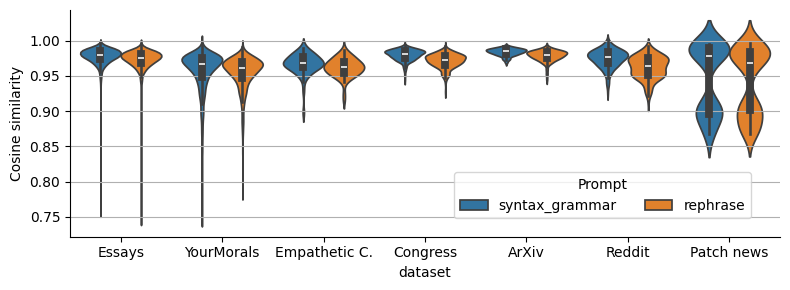

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(8, 3), sharey=True)
color_pallette = "Paired"
colors = plt.get_cmap(color_pallette)(np.linspace(0.15, 0.85, 4)).tolist()
colors = [[color] * 2 for color in colors]
colors = [color for sublist in colors for color in sublist]
for ax, model_in_use in zip([axs], ["gpt"]):

    bplot = sns.violinplot(
        similarities_dict_llms_df[(similarities_dict_llms_df["llm"] == model_in_use)],
        density_norm="width",
        x="dataset",
        y="similarity",
        hue="prompt",
        ax=ax,
    )

    ax.set_ylabel("Cosine similarity")
    ax.spines[["right", "top"]].set_visible(False)

    ax.grid(axis="y")

# change the legend to two columns and bottom right
handles, labels = ax.get_legend_handles_labels()
axs.legend(
    handles,
    [
        {val: key for key, val in REWRITTEN_TYPE_TO_SHORT.items()}[label]
        for label in labels
    ],
    title="Prompt",
    loc="lower center",
    bbox_to_anchor=(0.75, 0.05),
    ncol=2,
    alignment="center",
)
# change the x tick labels to their correct name using the dictionary labels_to_name
axs.set_xticklabels(
    [DATASET_TO_DATASET_NAME[label.get_text()] for label in axs.get_xticklabels()]
)

plt.tight_layout()
plt.savefig(f"figures/similarities_different_prompts.png", dpi=900, bbox_inches="tight")
plt.show()

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_39563/2613830544.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(


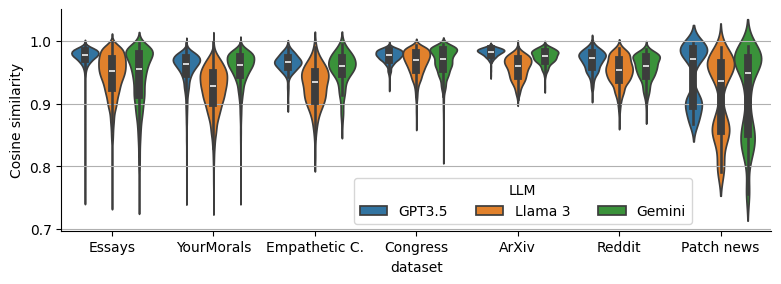

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(8, 3), sharey=True)
color_pallette = "Paired"
colors = plt.get_cmap(color_pallette)(np.linspace(0.15, 0.85, 4)).tolist()
colors = [[color] * 2 for color in colors]
colors = [color for sublist in colors for color in sublist]
for ax in [axs]:

    bplot = sns.violinplot(
        similarities_dict_llms_df,
        density_norm="width",
        x="dataset",
        y="similarity",
        hue="llm",
        ax=ax,
    )

    ax.set_ylabel("Cosine similarity")
    ax.spines[["right", "top"]].set_visible(False)

    ax.grid(axis="y")

# change the legend to two columns and bottom right
handles, labels = ax.get_legend_handles_labels()

axs.legend(
    handles,
    [LLM_TO_NAME[label] for label in labels],
    title="LLM",
    loc="lower center",
    bbox_to_anchor=(0.65, 0.00),
    ncol=3,
    alignment="center",
)
# change the x tick labels to their correct name using the dictionary labels_to_name
axs.set_xticklabels(
    [DATASET_TO_DATASET_NAME[label.get_text()] for label in axs.get_xticklabels()]
)

plt.tight_layout()
plt.savefig(f"figures/similarities_different_llms.png", dpi=900, bbox_inches="tight")
plt.show()

/Users/zhivar/anaconda3/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/zhivar/anaconda3/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/zhivar/anaconda3/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/zhivar/anaconda3/lib/python3.9/site-pac

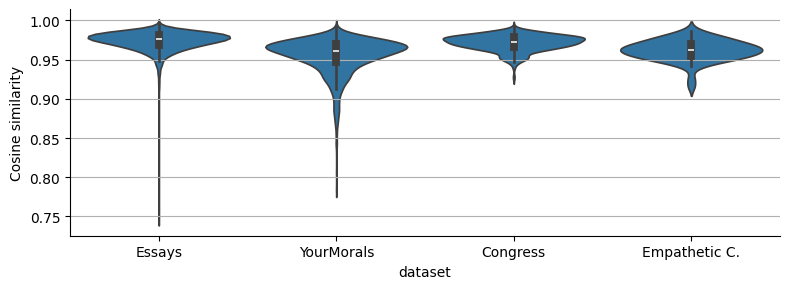

In [55]:
fig, axs = plt.subplots(1, 1, figsize=(8, 3), sharey=True)
color_pallette = "Paired"
colors = plt.get_cmap(color_pallette)(np.linspace(0.15, 0.85, 4)).tolist()
colors = [[color] * 2 for color in colors]
colors = [color for sublist in colors for color in sublist]
for ax, model_in_use in zip([axs], ["gpt"]):

    bplot = sns.violinplot(
        similarities_dict_llms_df[
            (similarities_dict_llms_df["llm"] == model_in_use)
            & (similarities_dict_llms_df["prompt"] == "R")
        ],
        density_norm="width",
        x="dataset",
        y="similarity",
        ax=ax,
        order=["essays", "facebook", "political", "wassa"],
    )

    ax.set_ylabel("Cosine similarity")
    ax.spines[["right", "top"]].set_visible(False)

    ax.grid(axis="y")

# change the legend to two columns and bottom right
handles, labels = ax.get_legend_handles_labels()
# axs.legend(
#     handles,
#     [
#         {val: key for key, val in REWRITTEN_TYPE_TO_SHORT.items()}[label]
#         for label in labels
#     ],
#     title="Prompt",
#     loc="lower center",
#     bbox_to_anchor=(0.75, 0.05),
#     ncol=2,
#     alignment="center",
# )
# change the x tick labels to their correct name using the dictionary labels_to_name
axs.set_xticklabels(
    [DATASET_TO_DATASET_NAME[label.get_text()] for label in axs.get_xticklabels()]
)

plt.tight_layout()
plt.savefig(f"figures/similarities_only_gpt_study3.png", dpi=900, bbox_inches="tight")
plt.show()